# Reconstructing $D(c)$ an $U_{\rm eq}$ from simulated Cathode GITT charging data
Using data from [Dandeliion simulation](https://simulation.dandeliion.com/legacy/simulation/?id=40751b48-307b-46fb-bcb9-5b3ab79b3b5c).

Assuming Cartesian diffusion equation, then using Sand equation to infer D. We also use the relaxation information to reconstruct $U_{eq}$ for the cathode.


In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from scipy.optimize import fsolve
# from IPython.display import display, clear_output, HTML
from scipy.integrate import quad

from fetch_Dandeliion import fetch_dandeliion

In [3]:
# pulse/relax simulation url:
GITT_url = 'https://simulation.dandeliion.com/legacy/simulation/?id=40751b48-307b-46fb-bcb9-5b3ab79b3b5c'
GITT_label = 'LGM50_cathode_halfcell_kickrelax'

simulation_save_dir = 'Dandeliion_Simulations/'
inference_save_dir = 'inference_data/'

In [4]:
os.makedirs(inference_save_dir, exist_ok=True) # create the folder for inference results if it doesn't exist

GITT_folder = simulation_save_dir + GITT_label+'/'

# If we already downloaded the data, don't bother fetching it. Just read the functions. Otherwise, extract the zip file
dled = os.path.isdir(GITT_folder)
# Only store D(x) and U_eq(x) in the cathode (we convert Dandeliion's diffusivity to SI units in fetch_diffusivity) and the current used in the submission of the simulation
_, D_c_true, _, Ueq_true, I_data_sub = fetch_dandeliion(GITT_url, GITT_label, save_dir= (None if dled else simulation_save_dir))

Here is the diffusivity used in the Dandeliion simulation

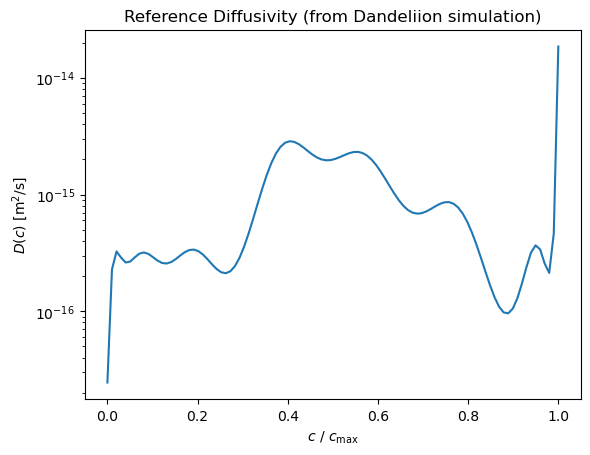

In [9]:
x_vals = np.linspace(0,1,100)
plt.plot(x_vals, D_c_true(x_vals))
plt.yscale("log")
plt.xlabel(r"$c~/~c_{\rm max}$")
plt.ylabel(r"$D(c) ~\mathrm{[m^2/s]}$") 
plt.title("Reference Diffusivity (from Dandeliion simulation)")
plt.show()

In [11]:
# Load Dandeliion data files

V_SI = np.loadtxt(GITT_folder + "voltage.dat", delimiter='\t',skiprows=1, usecols=[0,2])
I_SI = np.loadtxt(GITT_folder + "current_total.dat", delimiter='\t',skiprows=1, usecols=[0,1])
# Separate, t, I, V data:
t_SI, V_SI = V_SI.T
I_SI = I_SI[:,1]

We have two currents:
- `I_SI` which is the current recorded at times `t_SI`, and
- `I_data_sub` which are the time/current pairs used to generate the simulation.

These two are of course consistent, but the time resolution may not be the same for both currents, resulting in some features in the original current not being reflected in the recorded one. If in doubt, use `I_sub`, the linear interpolation of `I_data_sub` used by Dandeliion to solve the DFN model.

In [16]:
I_sub = lambda t: np.interp(t,*I_data_sub) # "sub" for "submitted"

In [20]:
# This is the RMS. Fully compatible.
print(np.sqrt(np.mean((I_sub(t_SI) - I_SI)**2)))

5.762193471197965e-11


Battery parameters used in the data. Read directly from the `input.log` file.

In [27]:
# Preparing containers for:
# - initial concentrations (anode, cathode), 
# - maximum concentrations (anode, cathode), 
# - particle radii (anode, cathode), 
# - active fraction (anode, cathode, separator), 
# - thicknesses (anode, cathode, separator)

c0_SI, cmax_SI, R_SI, eps_active, L_SI = [], [], [], [], [] 
A_SI = None  # To be read once
x_vals = None

# Mapping keys to containers
key_map = {'cs0': c0_SI, 'cmax': cmax_SI, 'R': R_SI, 'el': eps_active, 'L': L_SI}

def extract_value(s):
    return float(s.split('=')[-1])

# Read and process file
with open(GITT_folder + "input.log") as f:
    for line in f:
        line_content = line.strip().split('\t')
        key = line_content[0]

        if key in key_map:
            val = extract_value(line_content[-1])
            # Special case for electrolyte fraction 'el' to convert to active material fraction
            key_map[key].append(1 - val if key == 'el' else val)
        elif key == 'A': # Surface area
            A_SI = extract_value(line_content[-1])
        elif key == 'cs_x': # values in the x direction
            x_vals = np.fromstring(line_content[-1].split('=')[-1], sep=' ')

In [25]:
extr

NameError: name 'A_SI' is not defined

Since this is a half-cell simulation, we only use the cathode values below

In [21]:
F = 96485.3321 # Faraday's constant [C/mol]
# Electrode Volume. 
V_electrode = A_SI*L_SI[1] # Volume [m^3]
area_by_volume_particle = 3/R_SI[1]  # [1/m]
V_particle = 4*np.pi/3*R_SI[1]**3 # Particle volume [m^3]
S_particle = 4*np.pi*R_SI[1]**2 # Particle surface area [m^2]
Np = eps_active[1] * V_electrode / V_particle # Number of active particles
# Contact surface area of electrode with electrolyte
S_contact = eps_active[1] * V_electrode * area_by_volume_particle  # [m^2]


Now, since we are dealing with a Kick/Relax data, we need to determine the indices at which there is a switch/on -- switch/off.

The data was cut-off at V=4.2 V, so the last point is part of a non-zero current (kick). We will not use the kick, but will still use the preceding off state to infer the equilibrium potential.

In [24]:
idx_nonzero = np.where(I_SI !=0)[0][:-1] # points where I != 0
idx_zero = np.where(I_SI ==0)[0] # points where I = 0

# points where I=0 switched to I != 0 
idx_on = np.r_[1,idx_nonzero[np.where(np.diff(idx_nonzero) !=1)[0]+1]]

# and points where I !=0 switched to I=0
idx_off = idx_zero[np.where(np.diff(idx_zero) !=1)[0]+1]

# Combine all switches, on and off
idx_switch = np.sort(np.r_[idx_on, idx_off])

# The final index, if we ignore the last relaxation period.
idx_end = idx_on[-1]

# Initial condition for c:
We first check the average (over particle radius, then $x$) concentrations in the data are consistent with charge conservation

In [27]:
# Initial stoichiometry
x0 = c0_SI[1]/cmax_SI[1]

### Checking consistency of average concentrations in the data with charge concentration constructed with $I_{sub}$

First, compute the concentration averaged over the particle size then x direction

In [30]:
# From x values, read corresponding files for concentration
x_vals_str = [f"{x:.6f}" for x in x_vals]

dfs = [pd.read_csv(GITT_folder + f"cs_solid_cathode_xrel={x}.dat", delimiter='\t') for x in x_vals_str]

# Extract r and t values from the first data frame
r_vals = dfs[0].iloc[:,0].to_numpy()
t_vals = np.array([float(t.lstrip("t=")) for t in dfs[0].columns[1:]])
c_vals_list = [df.iloc[:,1:].to_numpy() for df in dfs]

# Function to compute particle-averaged concentration at each time for given c_vals
def compute_c_av(c_vals, r_vals):
    num = np.trapezoid(c_vals.T * r_vals**2, r_vals, axis=1)
    denom = np.trapezoid(r_vals**2, r_vals)
    return num / denom  # (time_points, )

# Compute particle averages and stack them
c_av_list = [compute_c_av(c_vals, r_vals) for c_vals in c_vals_list]
c_av = np.vstack(c_av_list)  # shape: (len(x_vals), len(t_vals))

# Average over x direction and convert to stoichiometry (unfortunate notation, also x):
x_av_data = np.trapezoid(c_av, x_vals, axis=0)/x_vals[-1]/cmax_SI[1]

The above should be equal to the total moles of Li ions  transferred per particle per volume 

In [33]:
# Charge transfer at each time point. In the integration, we 
# let quad know where the discontinuities are to help with
# local difficulties.
delta_Q_vals = np.r_[0,[quad(I_sub, t_vals[i-1],t_vals[i], points=I_data_sub[0])[0] for i in range(1,len(t_vals))]]

Q_vals = np.cumsum(delta_Q_vals)
x_estimate = (x0-Q_vals/F/Np/V_particle/cmax_SI[1])

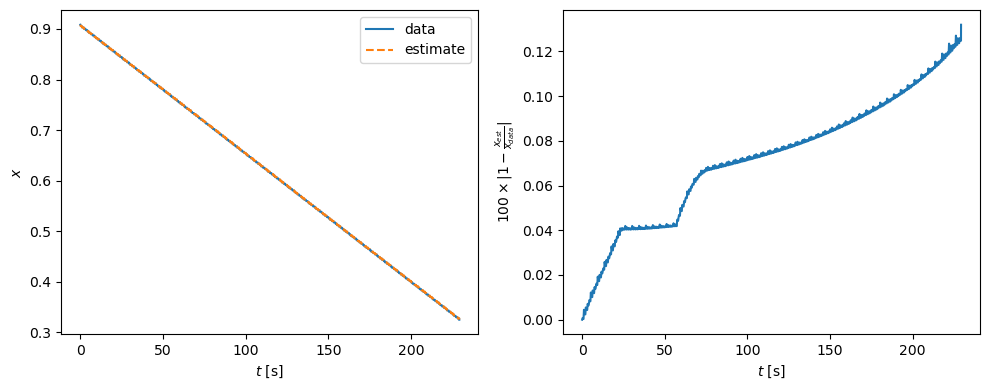

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t_vals/3600, x_av_data, label="data")
plt.plot(t_vals/3600, x_estimate, '--',label="estimate")
plt.ylabel(r"$|x_{data} - x_{est}|$")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$x$")
plt.legend()
plt.subplot(1,2,2)
plt.plot(t_vals/3600, 100*np.abs(1-x_estimate/x_av_data))
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$100\times |1 - \frac{x_{est}}{x_{data}}|$")
plt.tight_layout()
plt.show()

The agreement between the data (concentration averaged over $r$ and $x$) and estimate (from integrals of $I_{sub}$) is within ~0.1%.

### Stoichiometry estimates at each data point
Now, we use charge conservation to estimate the amount of charge transferred at each time available in `t_SI` and obtain the corresponding stoichiometries.

Although `t_SI` is very dense, it does miss some of the on/off switches. To accurately compute the transferred charge we use the adaptive `quad`. It is extremely slow for the $8\times10^5$ data points, so we speed it up with parallelism.

In [39]:
%%time 
from multiprocessing import Pool
from scipy.integrate import quad

# Charge transferred in one step in t_SI
def delta_Q_step(i):
    return quad(I_sub, t_SI[i-1], t_SI[i], points=I_data_sub[0])[0]

# Do these in parallel
with Pool() as pool:
    delta_Q_SI = pool.map(delta_Q_step, range(1, len(t_SI)))

# Add zero to initialise.
delta_Q_SI = np.r_[0, delta_Q_SI]

# Accumulated charge at each time in t_SI
Q_SI = np.cumsum(delta_Q_SI)
x_SI = x0 - Q_SI / F/Np/V_particle/cmax_SI[1]

CPU times: user 148 ms, sys: 91.2 ms, total: 239 ms
Wall time: 3.87 s


# Cathode delithiation [charging]

For each pulse, use
$$
D_s = \frac{4}{\pi}\left(\frac{j\,U_{eq}'(c_0)}{\frac{\partial V}{\partial \sqrt{t}}}\right)^2 = 
\frac{4}{\pi\,\tau^2}\left(\frac{\Delta V}{\frac{\partial V}{\partial \sqrt{t}}}\right)^2 \,\left(\frac{R}{3}\right)^2\,,
$$
where $\tau$ is the duration of the pulse, $\Delta V=V_{end}-V_{in}$ is the change in the (equilibrium) potential after 1 pulse/relaxation period and $\frac{\partial V}{\partial \sqrt{t}}$ is evaluated during the pulse by fitting $V$ to $\sqrt{t}$.

Note that in the above, we approximated $U_{eq}'(c) \approx \Delta U_{eq}/\Delta c$, and used that $\Delta c = \frac{j\,\tau\,4\,\pi\,R^2\tau}{\frac43\,\pi R^3} = \frac{3\,j\,\tau}{R}$. Note that this approach requires that during $\tau$, the current stays constant. Therefore, $\tau$ should be the full duration of the current, but it must be ensured that the current is more or less constant.

The algebraic variant (see Weppner/Huggins'77 Eq.[38]) instead approximates the derivative $\partial V/\partial\sqrt{t} \simeq \Delta V_{\rm pulse} / \sqrt{\tau}$ (where time is redefined to start with the pulse)
$$ 
D_s = 
\frac{4}{\pi\,\tau}\left(\frac{\Delta V}{\Delta V_{pulse}}\right)^2 \,\left(\frac{R}{3}\right)^2\,,
$$
where $\Delta V_{\rm pulse}$ is the change in the potential from the beginning to the end of the pulse.

We construct lists of $\tau$, $\partial V / \partial \sqrt{t}$, $\Delta V$ and $\delta c$ for each period below

The algebraic variant is more susceptible to the left/right shifts. In fact, when there is a quick drop in the potential (due to last current value not being constant anymore), $\Delta V_{\rm pulse}$ is underestimated, then $D(c)$ over-estimated. This causes peaks in the $D(c)$ due to inconsistent slicing of the GITT periods (some have almost constant current, some also capture the gradual decrease at the end). The usual GITT (obtained by fitting) is less susceptible, and causes a relative change < 1%.

In [16]:
def apply_GITT(t_SI, I_SI, V_SI, R, idx_on, idx_off, I_threshold=1.e-4):
    """
    Apply GITT to infer D(c) using the standard GITT and Weppner-Huggins
    Inputs (all in SI units):
    t_SI        :  time (vector)
    I_SI        :  current timeseries (vector)
    V_SI        :  Voltage timeseries (vector)
    R           :  Average particle radius (scalar)
    idx_on      :  timeseries indices where kick starts
    idx_off     :  timeseries indices where relaxation starts
    I_threshold : Introduced to avoid non-constant current in the kick period. 
                    Weppner-Huggins particularly sensitive to this. 
                    Removes kick points for which I < I_threshold. Should be 
                    chosen to be close to the constant current (from below).

    Outputs (all in SI units):
    
    my_D_charge      :  D(c) obtained with the \partial V / \partial \sqrt{t} fitting
    my_D_charge_wh   :  D(c) obtained with the algebraic variant Weppner-Huggins
    R2_list          :  R^2 values of the \partial V / \partial \sqrt{t} fitting
    ratio_fit_points :  fraction of points used in each kick/relax period
    """
    
    tau_list = [] # tau
    V_slopes = [] # d V /d tau^0.5
    V_slopes_wh = [] # (V2-V1)/sqrt(tau) Weppner huggins.
    DV_list = [] # Delta V
    R2_list =[] # R2 of the linear fit of \sqrt{tau}

    # points within a pulse that are less than the threshold I are dropped
    fit_shift_left_list=[]
    fit_shift_right_list=[]
    
    # The remaining points are used in the fit
    num_fit_points = []
    
    for pulse in range(len(idx_off)):
        on_ini = idx_on[pulse]
        on_end = idx_off[pulse]-1
        off_ini = idx_off[pulse]
        off_end = idx_on[pulse+1]-1
        
        I_pulse = I_SI[on_ini:on_end+1]
    
        # Find the points where current is non-zero and constant. For this data, I use a threshold current.
        fit_shift_left = np.where(I_pulse>I_threshold)[0][0]
        fit_shift_right = len(I_pulse) - np.where(I_pulse>I_threshold)[0][-1] - 1
        
        V_pulse = V_SI[on_ini+fit_shift_left:off_ini-fit_shift_right]
        t_pulse = t_SI[on_ini + fit_shift_left : off_ini - fit_shift_right] - t_SI[on_ini+fit_shift_left]
        tau = t_pulse[-1]-t_pulse[0]
        # linear fit V to \sqrt{t}
        V_slope, V_intercept  = np.polyfit(np.sqrt(t_pulse), V_pulse, deg=1)
        
        
        Vin = V_SI[on_ini-1] if on_ini !=0 else V_charge[on_ini]  # Potential before pulse starts
        Vend = V_SI[off_end]                                      # potential at the end of relaxation
        V_fit = V_slope*np.sqrt(t_pulse)+V_intercept
        V_mean = V_pulse.mean()
        SS_tot = np.sum((V_pulse-V_mean)**2)
        SS_res = np.sum((V_pulse-V_fit)**2)
        R2 = 1- SS_res/SS_tot
        DV = Vend - Vin
        V_slope_wh = (V_SI[on_ini+fit_shift_left] - V_SI[on_end-fit_shift_right])/np.sqrt(tau)
        
        tau_list.append(tau)
        V_slopes.append(V_slope)
        V_slopes_wh.append(V_slope_wh)
        DV_list.append(DV)
        R2_list.append(R2)
        fit_shift_left_list.append(fit_shift_left)
        fit_shift_right_list.append(fit_shift_right)
        num_fit_points.append(off_ini-on_ini-fit_shift_left-fit_shift_right)
    
    V_slopes = np.array(V_slopes)
    V_slopes_wh = np.array(V_slopes_wh)
    tau_list = np.array(tau_list)
    DV_list = np.array(DV_list)
    num_fit_points = np.array(num_fit_points)
    fit_shift_left_list = np.array(fit_shift_left_list)
    fit_shift_right_list = np.array(fit_shift_right_list)
    
    my_D_charge = 4/np.pi/tau_list**2*(R/3)**2*(DV_list/V_slopes)**2
    my_D_charge_wh = 4/np.pi/tau_list**2*(R/3)**2*(DV_list/V_slopes_wh)**2
    R2_list = np.array(R2_list)
    ratio_fit_points = num_fit_points/(num_fit_points+fit_shift_left_list + fit_shift_right_list)
    
    return my_D_charge, my_D_charge_wh, R2_list, ratio_fit_points 

In [17]:
x_relaxed = x_SI[idx_on-1]
V_relaxed = V_SI[idx_on-1]

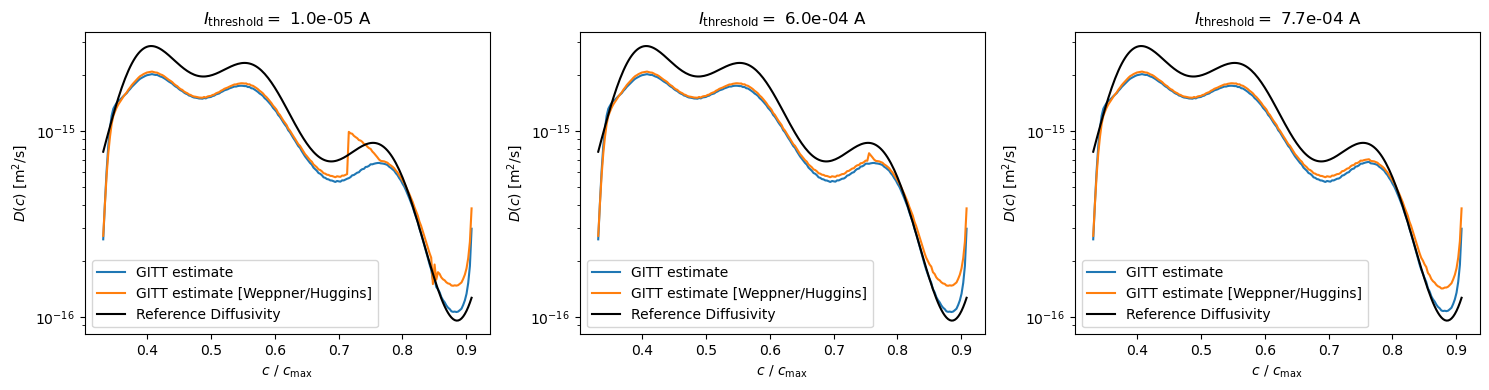

In [18]:
# Try for a few values of I_tolerance
I_tolerances = [1e-5, 6.e-4, 7.7e-4]
D_estimates = []
D_estimates_WH = []
R2_values = []
fraction_fit_points = []

plt.figure(figsize=(15,4))
fig = 1
for I_tolerance in I_tolerances:
    D_est, D_est_WH, R2, fraction_points = apply_GITT(t_SI, I_SI, V_SI, R_SI[1], idx_on, idx_off, I_threshold=I_tolerance)
    D_estimates.append(D_est)
    D_estimates_WH.append(D_est_WH)
    R2_values.append(R2)
    fraction_fit_points.append(fraction_points)
    plt.subplot(1,3,fig)
    plt.plot(x_relaxed[:-1], D_est, label="GITT estimate")
    plt.plot(x_relaxed[:-1], D_est_WH,  label="GITT estimate [Weppner/Huggins]")
    plt.plot(x_relaxed[:-1], D_c_true(x_relaxed[:-1]), c='k', label="Reference Diffusivity")
    plt.yscale("log")
    plt.xlabel(r"$c~/~c_{\rm max}$")
    plt.ylabel(r"$D(c) \mathrm{~[m^2/s]}$")
    plt.legend()
    plt.title(r"$I_{{ \rm threshold}} = $ {:.1e} A".format(I_tolerance))
    fig += 1
plt.tight_layout()
plt.show()

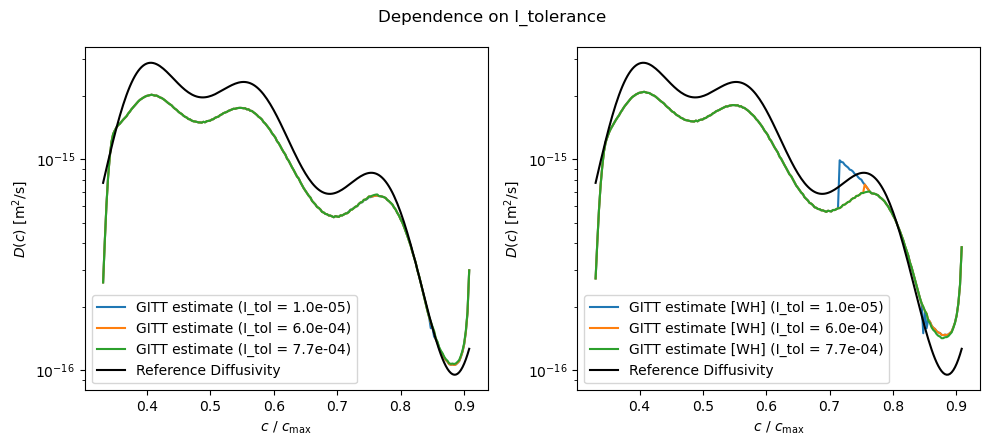

In [19]:
plt.figure(figsize=(10,4.5))
for D_est, D_est_WH, I_tol in zip(D_estimates, D_estimates_WH, I_tolerances):
    plt.subplot(1,2,1)
    plt.plot(x_relaxed[:-1], D_est, label=f"GITT estimate (I_tol = {I_tol:.1e})")
    plt.subplot(1,2,2)
    plt.plot(x_relaxed[:-1], D_est_WH, label=f"GITT estimate [WH] (I_tol = {I_tol:.1e})")
    
for i in [1,2]:
    plt.subplot(1,2,i)
    plt.plot(x_relaxed[:-1], D_c_true(x_relaxed[:-1]), c='k', label="Reference Diffusivity")
    plt.yscale("log")
    plt.xlabel(r"$c~/~c_{\rm max}$")
    plt.ylabel(r"$D(c) \mathrm{~[m^2/s]}$")
    plt.legend()

plt.suptitle("Dependence on I_tolerance ")
plt.tight_layout()
plt.show()

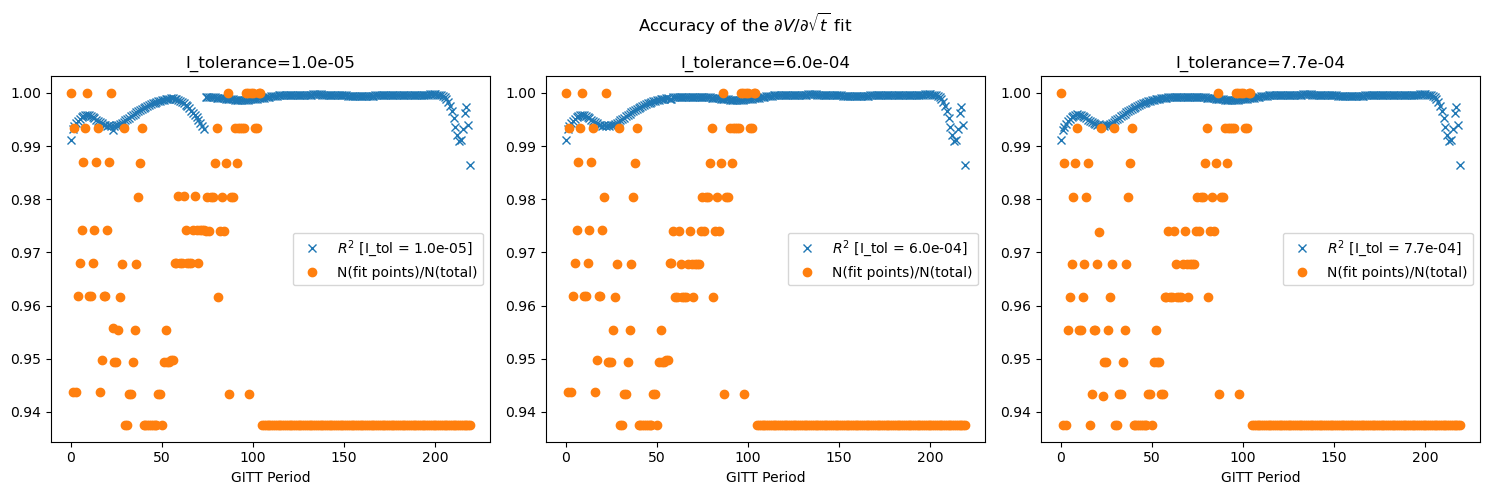

In [20]:
plt.figure(figsize=(15,5))
fig=1
for R2, frac_point, I_tol in zip(R2_values, fraction_fit_points, I_tolerances):
    plt.subplot(1,3,fig)
    plt.plot(R2,'x', label=r"$R^2$ [I_tol = {:.1e}]".format(I_tol))
    plt.plot(frac_point, 'o', label=r"N(fit points)/N(total)")
    plt.xlabel("GITT Period")
    plt.legend()
    plt.title(f"I_tolerance={I_tol:.1e}")
    fig +=1

plt.suptitle(r"Accuracy of the $\partial V/\partial\sqrt{t}$ fit")
plt.tight_layout()
plt.show()

In [21]:
# Save the inferred result (I_tol = 7.7e-4)
df_D_charge = pd.DataFrame({"c_cmax" : x_relaxed[:-1], "D_SI" : D_estimates[-1], "D_wh_SI" : D_estimates_WH[-1]})

In [22]:
df_D_charge.to_csv(inference_save_dir + "D_GITT_simulation.csv", index =False)

## Accuracy of the inferred $D(c)$
We now define
$$
R^2_D(D) = 1 - \frac{\Big\langle \left(D(c) -D_{\rm ref}(c) \right)^2 \Big\rangle_c}{\Big\langle\left( D_{\rm ref}(c) - \langle D_{\rm ref}(c)\rangle_c\right)^2 \Big\rangle_c	}
$$
which quantifies the proximity of the inferred diffusivity to its reference counterpart.

In [23]:
D_ref_mean = np.trapezoid(D_c_true(x_relaxed[:-1]), x_relaxed[:-1]) / (x_relaxed[-2] - x_relaxed[0])
D_ref_var = np.trapezoid((D_c_true(x_relaxed[:-1]) - D_ref_mean)**2, x_relaxed[:-1]) / (x_relaxed[-2] - x_relaxed[0])
print("R^2 values for the estimates:")
print("-"*30)

for D_est, D_est_WH, I_tol in zip(D_estimates, D_estimates_WH, I_tolerances):
    MSE_D = np.trapezoid((D_est - D_c_true(x_relaxed[:-1]))**2, x_relaxed[:-1]) / (x_relaxed[-2] - x_relaxed[0])
    R2D_D = 1 - MSE_D/D_ref_var
    MSE_DWH = np.trapezoid((D_est_WH - D_c_true(x_relaxed[:-1]))**2, x_relaxed[:-1]) / (x_relaxed[-2] - x_relaxed[0])
    R2D_DWH = 1 - MSE_DWH/D_ref_var
    print(f"  I_tolerance = {I_tol:.1e}")
    print(f"    D: {R2D_D:.5f}      D_WH: {R2D_DWH:.5f}") 


R^2 values for the estimates:
------------------------------
  I_tolerance = 1.0e-05
    D: 0.77966      D_WH: 0.81085
  I_tolerance = 6.0e-04
    D: 0.77971      D_WH: 0.80953
  I_tolerance = 7.7e-04
    D: 0.77977      D_WH: 0.80935


## Estimate $U_{eq}$

Using the voltages (and stoichiometry) just before the `on` switch, we reconstruct the equilibrium potential.

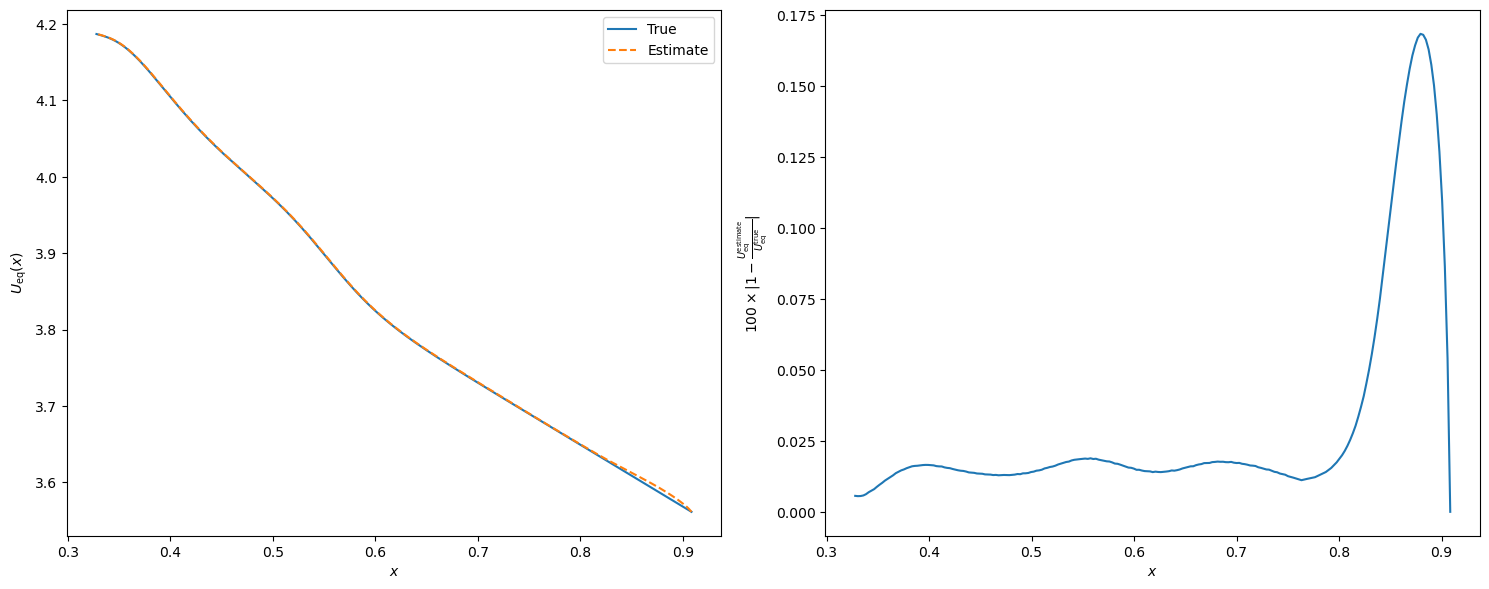

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(x_relaxed, Ueq_true(x_relaxed), label="True")
plt.plot(x_relaxed, V_relaxed, '--', label="Estimate")
plt.xlabel(r"$x$")
plt.ylabel(r"$U_{\rm eq}(x)$")
plt.legend()
plt.subplot(1,2,2)
plt.plot(x_relaxed, 100*np.abs(1-V_relaxed/Ueq_true(x_relaxed)), label="True")
plt.xlabel(r"$x$")
plt.ylabel(r"$100\times |1 - \frac{U_{\rm eq}^{\rm estimate}}{U_{\rm eq}^{\rm true}}|$")
plt.tight_layout()
plt.show()

The match is pretty good here. Can recover the original U_eq with a very high $R^2$

In [25]:
U_true_mean = np.trapezoid(Ueq_true(x_relaxed), x_relaxed)/(x_relaxed[-1]-x_relaxed[0])
U_true_var =  np.trapezoid((Ueq_true(x_relaxed) - U_true_mean)**2, x_relaxed)/(x_relaxed[-1]-x_relaxed[0])
U_MSE = np.trapezoid((V_relaxed - Ueq_true(x_relaxed) )**2, x_relaxed)/(x_relaxed[-1]-x_relaxed[0])
R2_U = 1 - U_MSE/U_true_var
print(R2_U)

0.9999099593393257


We save the U_eq inferred from GITT by sorting the stoichiometry data

In [26]:
idx_sorted = np.argsort(x_relaxed)

df_U_charge = pd.DataFrame({"c_cmax" : x_relaxed[idx_sorted], "Ueq_V" : V_relaxed[idx_sorted]})

df_U_charge.to_csv(inference_save_dir + "Ueq_GITT_simulation.csv", index=False)